In [1]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from IPython.display import display, Audio
import os
import audio_utils
import random
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
bg_dir = '../../LibriVox_Kaggle/BGnoise/'
rir_dir = '../../RIR/MIT_IR_Survey/Audio/'
bg_files = os.listdir(bg_dir)
rir_files = os.listdir(rir_dir)[1:]

csv_f = 'Librivox_fnames.csv'
csv_f0 = '../speechRemoval/fin_dataframe.csv'

df0 = pd.read_csv(csv_f0)
df = pd.read_csv(csv_f)

In [3]:
noise = audio_utils.add_two_noise([random.choice(df['aud_fname']), random.choice(df0['file1'])], [5])
feats = audio_utils.get_random_audioFeatures(noise)
feats.shape

torch.Size([1, 40, 251])

In [136]:
df.iloc[56,0]

'/work/dpandya/LibriVox_Kaggle/achtgesichterambiwasse/achtgesichterambiwasse_0060.wav'

In [103]:
class audioDataset(Dataset):

    def __init__(self, clean_aud_df, noise_df):
        self.clean_df = clean_aud_df
        self.noise_df = noise_df
        self.SNR = [10]

    def __len__(self):
        return len(self.clean_df)
    
    def __getitem__(self, index):

        audio_path = self.clean_df.iloc[index,0]
        noise_path_1 = random.choice(self.noise_df['file1'])
        self.SNR = [10]
        
        noise = audio_utils.add_two_noise([audio_path, noise_path_1], self.SNR)
        noise_feats = audio_utils.get_random_audioFeatures(noise)
        if torch.isnan(noise_feats).any():
            noise_feats = torch.zeros(noise_feats.shape)

        return noise[:,0:(5*16000)], noise_feats

In [104]:
from sklearn.model_selection import train_test_split

split = (int)(len(df)*0.8)
train_dataset = audioDataset(df[0:split], df0)
test_dataset = audioDataset(df[split:], df0)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [98]:
import torch

torch.manual_seed(13)
torch.cuda.manual_seed(13)

class logMelAE(nn.Module):

    def __init__(self):
        super(logMelAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 512, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(),

            nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
    
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=(3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(32, 64, kernel_size=(3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 128, kernel_size=(3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 256, kernel_size=(3), stride=1, padding=1),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 512, kernel_size=(3), stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(512, 1, kernel_size=(3,2), stride=2, padding=1, output_padding=1),
            nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [100]:
rrm = torch.rand([1, 40, 251])

encoder = nn.Sequential(
    nn.Conv2d(1, 512, kernel_size=3, stride=2, padding=1), 
    nn.LeakyReLU(),

    nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1),
    nn.LeakyReLU(),

    nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    
    nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),

    nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),

    nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU()
)

decoder = nn.Sequential(
    nn.ConvTranspose2d(16, 32, kernel_size=(3), stride=(1), padding=1),
    nn.LeakyReLU(),

    nn.ConvTranspose2d(32, 64, kernel_size=(3), stride=1, padding=1),
    nn.LeakyReLU(),

    nn.ConvTranspose2d(64, 128, kernel_size=(3), stride=1, padding=1),
    nn.LeakyReLU(),

    nn.ConvTranspose2d(128, 256, kernel_size=(3), stride=1, padding=1),
    nn.LeakyReLU(),

    nn.ConvTranspose2d(256, 512, kernel_size=(3), stride=2, padding=1, output_padding=1),
    nn.LeakyReLU(),

    nn.ConvTranspose2d(512, 1, kernel_size=(3,2), stride=2, padding=1, output_padding=1),
    nn.LeakyReLU()
)

rrm.shape, logMelAE().encoder(rrm).shape

(torch.Size([1, 40, 251]), torch.Size([16, 10, 63]))

In [105]:
#(torch.Size([1, 40, 251]), torch.Size([16, 10, 63]), torch.Size([1, 40, 251]))
autoEncoder = logMelAE()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

autoEncoder = autoEncoder.to(device)

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(autoEncoder.parameters(), lr=0.001)

In [115]:
import statistics
autoEncoder = autoEncoder.to(device)
epochs = 10

for epoch in range(0,epochs):
    loss_list = []
    for data in train_loader:

        autoEncoder.train()
        noise, feats_ = data
        if not torch.isnan(feats_).any():
            feats_ = feats_.to(device)

            outputs = autoEncoder(feats_)

            loss = loss_fn(outputs, feats_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {statistics.mean(loss_list)}")

Epoch [1/10] Loss: 2.436113365699457
Epoch [2/10] Loss: 2.240452872266589
Epoch [3/10] Loss: 2.193459389858718
Epoch [4/10] Loss: 2.1360825149252944
Epoch [5/10] Loss: 2.054301271272018
Epoch [6/10] Loss: 1.9445716985969044
Epoch [7/10] Loss: 1.9418719779629547
Epoch [8/10] Loss: 1.883177109680842
Epoch [9/10] Loss: 1.8226612008121164
Epoch [10/10] Loss: 1.785299764102897


In [116]:
noise = audio_utils.add_two_noise([random.choice(df['aud_fname']), random.choice(df0['file1'])], [5])
featsEval = audio_utils.get_random_audioFeatures(noise)

autoEncoder = autoEncoder.cpu()
autoEncoder.eval()
with torch.inference_mode():
    y_feats = autoEncoder(featsEval)

featsEval, y_feats

(tensor([[[-29.9466, -20.8617, -17.2549,  ..., -31.2009, -39.0514, -33.1333],
          [-21.0204, -21.5579, -23.7653,  ..., -32.7073, -34.3206, -26.3712],
          [-19.2926, -14.7776, -14.2530,  ..., -35.1491, -35.2508, -29.5121],
          ...,
          [-55.3993, -57.6268, -53.9306,  ..., -51.3821, -50.6144, -50.4984],
          [-55.5525, -54.6012, -51.3265,  ..., -52.3396, -48.9060, -49.5315],
          [-58.6009, -58.7139, -54.3863,  ..., -57.7000, -53.0648, -50.4389]]]),
 tensor([[[-25.9678, -25.5721, -24.3947,  ..., -33.4981, -34.4444, -33.4921],
          [-22.7641, -20.6062, -20.9383,  ..., -32.4245, -31.2606, -32.2624],
          [-19.0383, -14.5291, -14.8388,  ..., -34.5226, -33.3017, -32.3948],
          ...,
          [-55.7734, -57.3672, -55.1554,  ..., -52.0249, -48.4358, -46.0370],
          [-56.1392, -58.3370, -55.0401,  ..., -53.9659, -50.1398, -47.9795],
          [-56.5191, -59.0083, -55.1084,  ..., -56.9809, -53.3146, -50.4655]]]))

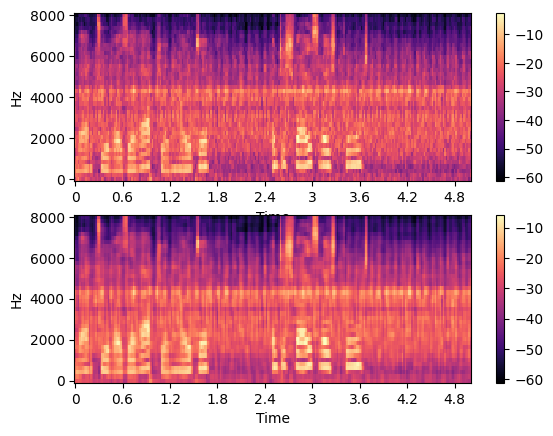

In [123]:
import librosa
import matplotlib.pyplot as plt

SAMPLE_RATE = 16000
N_MELS = 40
N_FFT = int(SAMPLE_RATE * 0.04)
HOP_LEN = int(SAMPLE_RATE * 0.02)

plt.subplot(2,1,1)
librosa.display.specshow(featsEval.squeeze().numpy(), sr=16000, hop_length=HOP_LEN, x_axis='time', y_axis='linear')
plt.colorbar()
plt.subplot(2,1,2)
librosa.display.specshow(y_feats.squeeze().numpy(), sr=16000, hop_length=HOP_LEN, x_axis='time', y_axis='linear')
plt.colorbar()

In [118]:
# 00 : Model conf00: 10 epochs: (torch.Size([1, 40, 251]), torch.Size([16, 10, 63]), torch.Size([1, 40, 251]))
# 01 : Model conf00: 20 epochs: (torch.Size([1, 40, 251]), torch.Size([16, 10, 63]), torch.Size([1, 40, 251]))

torch.save(autoEncoder.state_dict, 'models/logMelAE_model_01.pt')